# Calculating the Big Mac index

This R script shows how _The Economist_ calculates its Big Mac index.

We use the `tidyverse` and `data.table` packages for working with data generally.

We only calculate the Big Mac index for certain countries, specifically these ones:

In [1]:
library('tidyverse')
library('data.table')

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.5.1     v purrr   0.3.4
v tibble  3.2.1     v dplyr   1.1.4
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.5     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




In [2]:
big_mac_countries = c('FRA', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                      'EGY', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX', 'NZL',
                      'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF', 'KOR',
                      'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'ARE', 'USA', 'COL', 'CRI',
                      'PAK', 'LKA', 'UKR', 'URY', 'IND', 'VNM', 'GTM', 'HND', 'VEN',
                      'NIC', 'AZE', 'BHR', 'JOR', 'KWT', 'LBN', 'MDA', 'OMN',
                      'QAT', 'ROU', 'EUZ')

Our raw data sheet, compiled every six months, contains three sets of data: the local price of a Big Mac, the exchange rate of the local currency to the US dollar, and the GDP per person of the country (in US dollars). We have these data compiled into a single file already, so we can just load it:

In [3]:
big_mac_data = fread('./source-data/big-mac-source-data-v2.csv', na.strings = '#N/A') %>%
    .[!is.na(local_price)] %>%                    # remove lines where the local price is missing
    .[,GDP_local := as.numeric(GDP_local)] %>%    # convert GDP to a number
    .[order(date, name)]                          # sort by date and then by country name, for easy reading
tail(big_mac_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>
Ukraine,UKR,UAH,118.00,41.05000,5337.491,195637.25,2024-07-01
United Arab Emirates,ARE,AED,18.00,3.67300,51908.699,190634.70,2024-07-01
United States,USA,USD,5.69,1.00000,81632.253,81632.25,2024-07-01
Uruguay,URY,UYU,285.00,40.30000,21656.979,840754.62,2024-07-01
Venezuela,VEN,VES,181.60,36.56705,3659.195,107201.67,2024-07-01
Vietnam,VNM,VND,76000.00,25247.50000,4324.049,101912409.71,2024-07-01


In [5]:
latest_date = big_mac_data$date %>% max
latest_date

[1] "2024-07-01"

### Converting to a uniform currency

Our first step to calculate the index is to convert all of the prices to a uniform currency (we use the US dollar).

In [6]:
big_mac_data[, dollar_price := local_price / dollar_ex]
tail(big_mac_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>
Ukraine,UKR,UAH,118.00,41.05000,5337.491,195637.25,2024-07-01,2.874543
United Arab Emirates,ARE,AED,18.00,3.67300,51908.699,190634.70,2024-07-01,4.900626
United States,USA,USD,5.69,1.00000,81632.253,81632.25,2024-07-01,5.690000
Uruguay,URY,UYU,285.00,40.30000,21656.979,840754.62,2024-07-01,7.071960
Venezuela,VEN,VES,181.60,36.56705,3659.195,107201.67,2024-07-01,4.966220
Vietnam,VNM,VND,76000.00,25247.50000,4324.049,101912409.71,2024-07-01,3.010199


### Calculating the raw index

Now that we've done this, we can pick out our five 'base' currencies: the US dollar (USD), Euro (EUR), British pound (GBP), Japanese yen (JPY), and Chinese yuan (CNY).

In [7]:
base_currencies = c('USD', 'EUR', 'GBP', 'JPY', 'CNY')

Calculating the index is as simple as dividing the local price by the price in the base currency. We're using `data.table`'s grouping abilities to do this neatly.

In [8]:
big_mac_index = big_mac_data[
    !is.na(dollar_price) & iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price)]

for(currency in base_currencies) {
    big_mac_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            dollar_price /          # we divide the dollar price in each row by
                                    # the dollar price on the *base currency*'s row (.SD is a data.table
            .SD[currency_code == currency]$dollar_price -        # that contains only the current group)
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]
tail(big_mac_index)

Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"
Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"
Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"
Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"
Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"
Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"
Warning message in dollar_price/.SD[currency_code == currency]$dollar_price:
"longer object length is not a multiple of shorter object length"

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD,EUR,GBP,JPY,CNY
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-07-01,UKR,UAH,Ukraine,118.00,41.05000,2.874543,-0.49481,-0.52563,-0.51243,-0.09895,-0.18525
2024-07-01,ARE,AED,United Arab Emirates,18.00,3.67300,4.900626,-0.13873,-0.17658,-0.16877,0.53614,0.38901
2024-07-01,USA,USD,United States,5.69,1.00000,5.690000,0.00000,-0.06102,-0.03488,0.78358,0.61275
2024-07-01,URY,UYU,Uruguay,285.00,40.30000,7.071960,0.24288,0.18826,0.19952,1.21676,1.00444
2024-07-01,VEN,VES,Venezuela,181.60,36.56705,4.966220,-0.12720,-0.18046,-0.15765,0.55670,0.40760
2024-07-01,VNM,VND,Vietnam,76000.00,25247.50000,3.010199,-0.47097,-0.49422,-0.48942,-0.05643,-0.14680


We can also see a basic plot, like so:

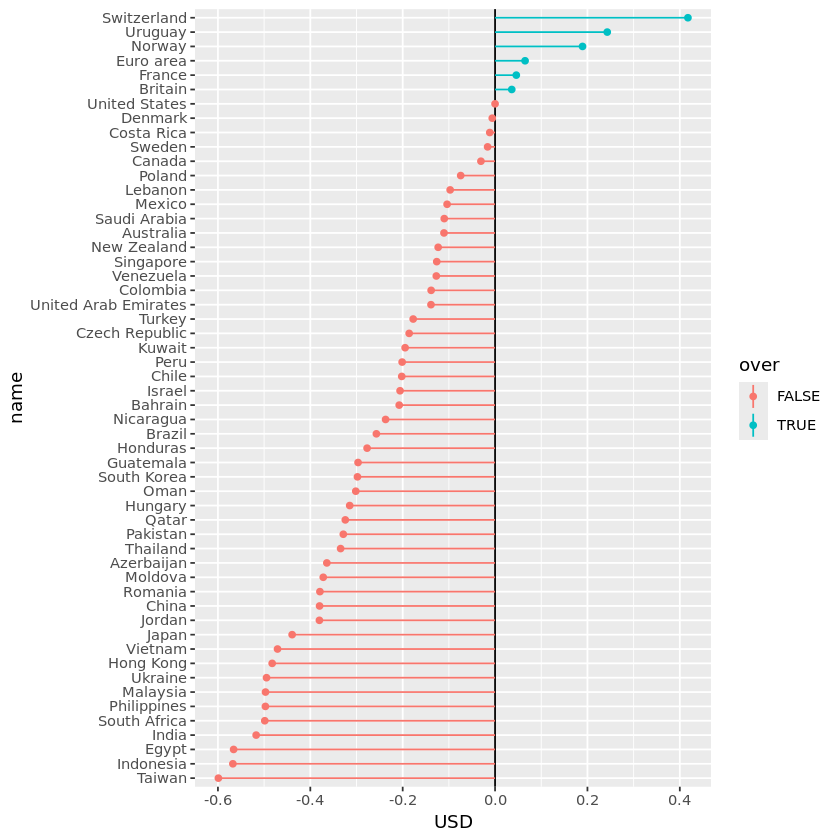

In [9]:
to_plot = big_mac_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

We've now calculated the index. We'll save it to a file.

In [10]:
fwrite(big_mac_index, './output-data/big-mac-raw-index.csv')

Lovely! We've got it. So what about that adjusted index?

## Calculating the adjusted index

While the Big Mac index is a refreshingly simple way of thinking about relative currency values, a common (and fair) objection to it is that burgers cannot be easily traded across borders. Given non-traded local inputs (rent and worker’s wages) one would expect Big Macs to be cheaper in poorer countries and dearer in wealthier ones.

We'll start out by only picking the countries where we have GDP data.

In [11]:
big_mac_gdp_data = big_mac_data[GDP_local > 0]
head(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>
Argentina,ARG,ARS,2.50,1.0000000,8709.072,8709.072,2000-04-01,2.500000
Australia,AUS,AUD,2.59,1.6800000,21780.066,33750.299,2000-04-01,1.541667
Brazil,BRA,BRL,2.95,1.7900000,3567.631,6471.445,2000-04-01,1.648045
Britain,GBR,GBP,1.90,0.6329114,28768.448,17777.384,2000-04-01,3.002000
Canada,CAN,CAD,2.85,1.4700000,22340.553,33191.468,2000-04-01,1.938776
Chile,CHL,CLP,1260.00,514.0000000,4985.768,2536663.274,2000-04-01,2.451362


In order to correct for the problem, we'll use a linear regression of GDP vs Big Mac Price.

We sometimes add or remove countries from the Big Mac index, but we want the list of countries on which we base the adjusted index to remain consistent. We use this list of countries to calculate the relationship between GDP and Big Mac price.

In [23]:
regression_countries = c('FRA', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                         'EGY', 'EUZ', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX',
                         'NZL', 'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF',
                         'KOR', 'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'USA', 'COL', 'PAK',
                         'IND', 'AUT', 'BEL', 'NLD', 'FIN', 'FRA', 'DEU', 'IRL', 'ITA',
                         'PRT', 'ESP', 'GRC', 'EST')
# in 2021, we added a number of additional countries to the adjusted index
regression_addons_2021 = c('ARE', 'CRI', 'LKA', 'UKR', 'URY', 'VNM', 'GTM', 'HND', 'NIC',
                           'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'MDA', 'OMN', 'QAT', 'ROU',
                           'SVK', 'SVN', 'LVA', 'LTU')
big_mac_gdp_data = big_mac_gdp_data[iso_a3 %in% regression_countries |
  (iso_a3 %in% regression_addons_2021 & date >= as.Date('2021-01-01'))
]

tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac,adj_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>,<dbl>
Turkey,TUR,TRY,155.00,33.1104,12849.000,304590.40,2024-07-01,4.681309,11181.415,4.275733
Ukraine,UKR,UAH,118.00,41.0500,5337.491,195637.25,2024-07-01,2.874543,9433.695,4.249705
United Arab Emirates,ARE,AED,18.00,3.6730,51908.699,190634.70,2024-07-01,4.900626,60261.746,5.006661
United States,USA,USD,5.69,1.0000,81632.253,81632.25,2024-07-01,5.690000,81632.253,5.324921
Uruguay,URY,UYU,285.00,40.3000,21656.979,840754.62,2024-07-01,7.071960,16785.592,4.359193
Vietnam,VNM,VND,76000.00,25247.5000,4324.049,101912409.71,2024-07-01,3.010199,7630.021,4.222844


We create a new "Big-Mac-adjusted per-capita GDP", which is the GDP in local currency, divided by the exchange rate as determined by Big Macs (that is, the price in local currency divided by the price in the United States). This performs a similar function to "purchasing-power parity" adjustments, but using only the price of a Big Mac to make the adjustment.

In [24]:
big_mac_gdp_data %>%
    .[,GDP_bigmac := GDP_local / (local_price / .SD[iso_a3=='USA']$local_price), by=date]
tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac,adj_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>,<dbl>
Turkey,TUR,TRY,155.00,33.1104,12849.000,304590.40,2024-07-01,4.681309,11181.415,4.275733
Ukraine,UKR,UAH,118.00,41.0500,5337.491,195637.25,2024-07-01,2.874543,9433.695,4.249705
United Arab Emirates,ARE,AED,18.00,3.6730,51908.699,190634.70,2024-07-01,4.900626,60261.746,5.006661
United States,USA,USD,5.69,1.0000,81632.253,81632.25,2024-07-01,5.690000,81632.253,5.324921
Uruguay,URY,UYU,285.00,40.3000,21656.979,840754.62,2024-07-01,7.071960,16785.592,4.359193
Vietnam,VNM,VND,76000.00,25247.5000,4324.049,101912409.71,2024-07-01,3.010199,7630.021,4.222844


Now that we have our consistent basket of "regression countries", we can run our regressions. We can see what that looks like:

`geom_smooth()` using formula = 'y ~ x'


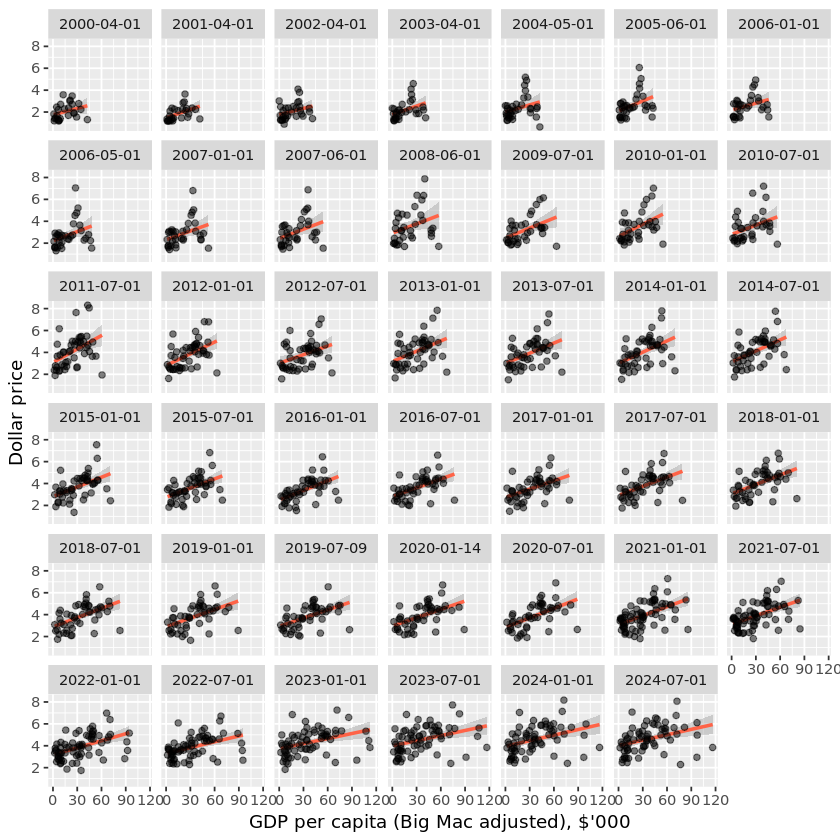

In [25]:
ggplot(big_mac_gdp_data, aes(x=GDP_bigmac, y=dollar_price)) +
    facet_wrap(~date)+
    geom_smooth(method = lm, color='tomato') +
    geom_point(alpha=0.5) +
    scale_x_continuous(labels=function(x) {round(x / 1000)}) +
    labs(y="Dollar price", x="GDP per capita (Big Mac adjusted), $'000")

We have to calculate the regressions separately for each date (ggplot did this for us above).

In [26]:
big_mac_gdp_data[date=='2022-07-01']

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac,adj_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>,<dbl>
Australia,AUS,AUD,6.70,1.448436,64327.187,85566.585,2022-07-01,4.625680,65771.330,4.459099
Austria,AUT,EUR,4.35,0.975850,53696.159,45369.626,2022-07-01,4.457652,53713.465,4.253688
Azerbaijan,AZE,AZN,4.70,1.698250,5468.269,9296.057,2022-07-01,2.767555,10186.105,3.512183
Bahrain,BHR,BHD,1.60,0.377000,26116.466,9819.791,2022-07-01,4.244032,31607.452,3.877104
Belgium,BEL,EUR,4.60,0.975850,52026.031,43958.481,2022-07-01,4.713839,49214.386,4.177045
Brazil,BRA,BRL,22.90,5.391750,8269.709,44610.048,2022-07-01,4.247230,10032.391,3.509565
Britain,GBR,GBP,3.69,0.831080,46704.465,33949.015,2022-07-01,4.440006,47381.417,4.145820
Canada,CAN,CAD,5.88,1.289150,52520.512,65854.257,2022-07-01,4.561145,57678.473,4.321234
Chile,CHL,CLP,3400.00,928.435000,16037.956,12173877.522,2022-07-01,3.662077,18439.844,3.652789


In [27]:
big_mac_gdp_data[
    ,
    `:=`(
        adj_price=lm(dollar_price ~ GDP_bigmac) %>% predict
#         adj_price_USD=lm(dollar_price ~ GDP_dollar) %>% predict
    ),
    by = date]
tail(big_mac_gdp_data)

name,iso_a3,currency_code,local_price,dollar_ex,GDP_dollar,GDP_local,date,dollar_price,GDP_bigmac,adj_price
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>,<dbl>,<dbl>,<dbl>
Turkey,TUR,TRY,155.00,33.1104,12849.000,304590.40,2024-07-01,4.681309,11181.415,4.199380
Ukraine,UKR,UAH,118.00,41.0500,5337.491,195637.25,2024-07-01,2.874543,9433.695,4.170525
United Arab Emirates,ARE,AED,18.00,3.6730,51908.699,190634.70,2024-07-01,4.900626,60261.746,5.009717
United States,USA,USD,5.69,1.0000,81632.253,81632.25,2024-07-01,5.690000,81632.253,5.362553
Uruguay,URY,UYU,285.00,40.3000,21656.979,840754.62,2024-07-01,7.071960,16785.592,4.291908
Vietnam,VNM,VND,76000.00,25247.5000,4324.049,101912409.71,2024-07-01,3.010199,7630.021,4.140745


If we've done everything right, all the points we just generated should be on those lines from above...

`geom_smooth()` using formula = 'y ~ x'


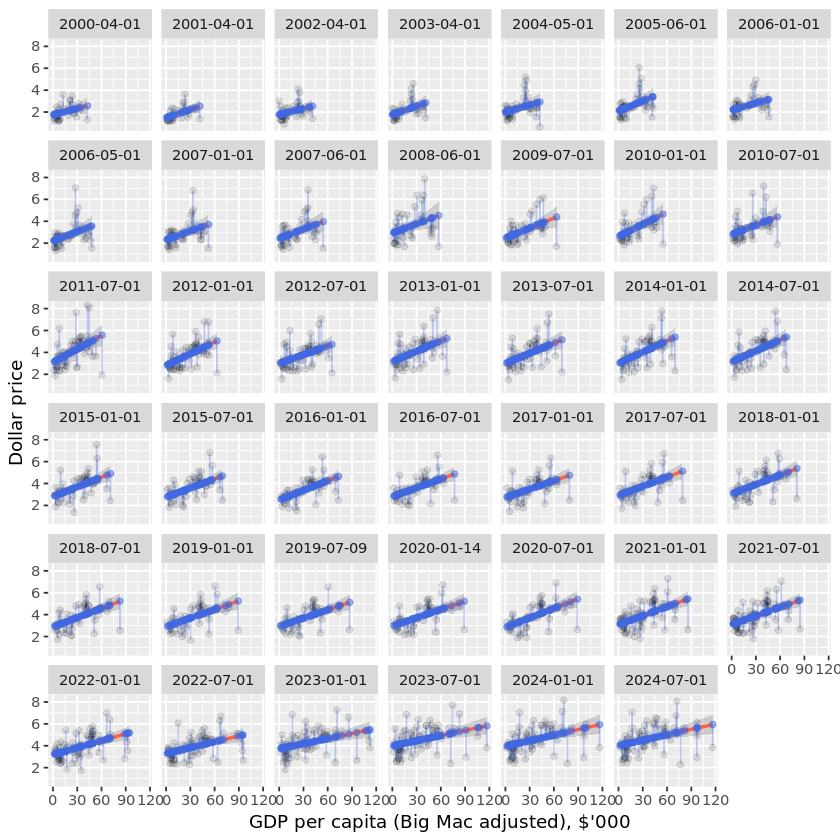

In [28]:
ggplot(big_mac_gdp_data, aes(x=GDP_bigmac, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_linerange(aes(ymin=dollar_price, ymax=adj_price), color='royalblue', alpha=0.3) +
    geom_point(alpha=0.1) +
    geom_point(aes(y=adj_price), color='royalblue', alpha=0.5) +
    scale_x_continuous(labels=function(x) {round(x / 1000)}) +
    labs(y="Dollar price", x="GDP per capita (Big Mac adjusted), $'000")

Yep, that's exactly what we wanted. So now that we've got these data, we can do almost the same thing as before.

In [29]:
big_mac_adj_index = big_mac_gdp_data[
    !is.na(dollar_price) &
    (
        iso_a3 %in% regression_countries |
        iso_a3 %in% regression_addons_2021 & date >= '2021-01-01'
    ) &
    iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price, GDP_bigmac, adj_price)]

for(currency in base_currencies) {
    big_mac_adj_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            (                       # we divide the dollar price by the adjusted price to get
                dollar_price / adj_price  # the deviation from our expectation by
            ) /
                                    # the same figure from the *base currency*'s rowa\
            (
                .SD[currency_code == currency]$dollar_price /
                .SD[currency_code == currency]$adj_price
            ) -
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_adj_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]

tail(big_mac_adj_index)

Warning message in (dollar_price/adj_price)/(.SD[currency_code == currency]$dollar_price/.SD[currency_code == :
"longer object length is not a multiple of shorter object length"
Warning message in (dollar_price/adj_price)/(.SD[currency_code == currency]$dollar_price/.SD[currency_code == :
"longer object length is not a multiple of shorter object length"
Warning message in (dollar_price/adj_price)/(.SD[currency_code == currency]$dollar_price/.SD[currency_code == :
"longer object length is not a multiple of shorter object length"
Warning message in (dollar_price/adj_price)/(.SD[currency_code == currency]$dollar_price/.SD[currency_code == :
"longer object length is not a multiple of shorter object length"
Warning message in (dollar_price/adj_price)/(.SD[currency_code == currency]$dollar_price/.SD[currency_code == :
"longer object length is not a multiple of shorter object length"
Warning message in (dollar_price/adj_price)/(.SD[currency_code == currency]$dollar_price/.SD[currency_code == 

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_bigmac,adj_price,USD,EUR,GBP,JPY,CNY
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-07-01,TUR,TRY,Turkey,155.00,33.1104,4.681309,11181.415,4.199380,0.05061,-0.13357,-0.08806,0.72770,0.37171
2024-07-01,UKR,UAH,Ukraine,118.00,41.0500,2.874543,9433.695,4.170525,-0.35041,-0.45091,-0.43615,0.06823,-0.15188
2024-07-01,ARE,AED,United Arab Emirates,18.00,3.6730,4.900626,60261.746,5.009717,-0.07807,-0.23969,-0.19976,0.51609,0.20370
2024-07-01,USA,USD,United States,5.69,1.0000,5.690000,81632.253,5.362553,0.00000,-0.15472,-0.13199,0.64447,0.30563
2024-07-01,URY,UYU,Uruguay,285.00,40.3000,7.071960,16785.592,4.291908,0.55292,0.28068,0.34794,1.55373,1.02754
2024-07-01,VNM,VND,Vietnam,76000.00,25247.5000,3.010199,7630.021,4.140745,-0.31487,-0.42087,-0.40530,0.12669,-0.10547


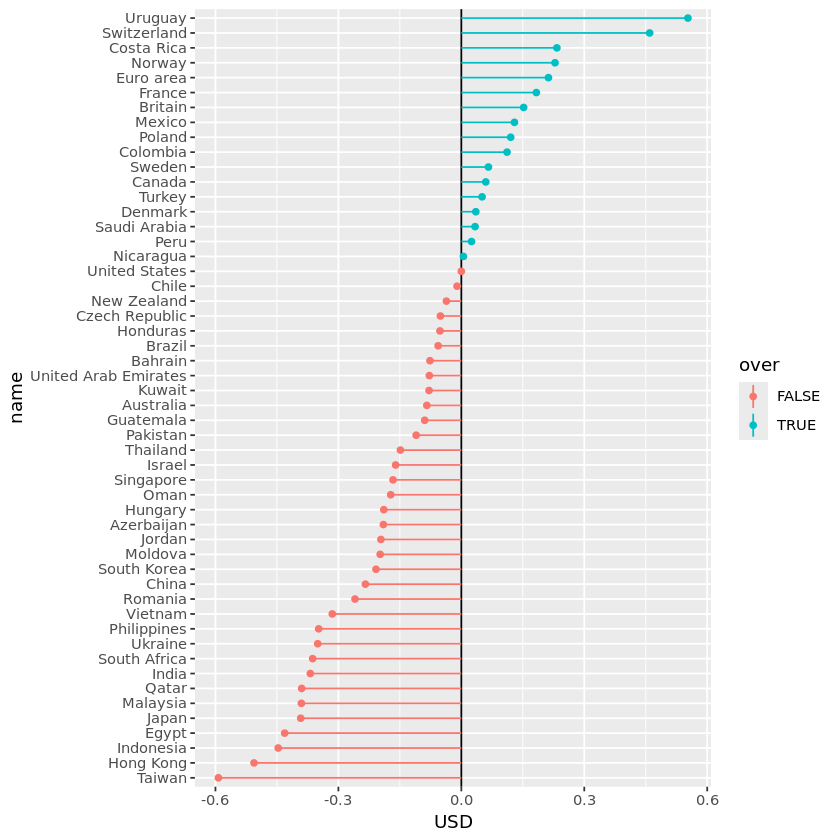

In [30]:
to_plot = big_mac_adj_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

In [31]:
fwrite(big_mac_adj_index, './output-data/big-mac-adjusted-index.csv')

Also, for tidiness, we'll generate a consolidated file with both indices in one table.

In [32]:
big_mac_full_index = merge(big_mac_index, big_mac_adj_index,
      by=c('date', 'iso_a3', 'currency_code', 'name', 'local_price', 'dollar_ex', 'dollar_price'),
      suffixes=c('_raw', '_adjusted'),
      all.x=TRUE
     )
tail(big_mac_full_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_bigmac,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-07-01,UKR,UAH,Ukraine,118.00,41.05000,2.874543,-0.49481,-0.52563,-0.51243,-0.09895,-0.18525,9433.695,4.170525,-0.35041,-0.45091,-0.43615,0.06823,-0.15188
2024-07-01,URY,UYU,Uruguay,285.00,40.30000,7.071960,0.24288,0.18826,0.19952,1.21676,1.00444,16785.592,4.291908,0.55292,0.28068,0.34794,1.55373,1.02754
2024-07-01,USA,USD,United States,5.69,1.00000,5.690000,0.00000,-0.06102,-0.03488,0.78358,0.61275,81632.253,5.362553,0.00000,-0.15472,-0.13199,0.64447,0.30563
2024-07-01,VEN,VES,Venezuela,181.60,36.56705,4.966220,-0.12720,-0.18046,-0.15765,0.55670,0.40760,NA,NA,NA,NA,NA,NA,NA
2024-07-01,VNM,VND,Vietnam,76000.00,25247.50000,3.010199,-0.47097,-0.49422,-0.48942,-0.05643,-0.14680,7630.021,4.140745,-0.31487,-0.42087,-0.40530,0.12669,-0.10547
2024-07-01,ZAF,ZAR,South Africa,51.90,18.19125,2.853020,-0.49859,-0.52063,-0.51608,-0.10570,-0.19135,12419.761,4.219826,-0.36281,-0.47451,-0.44691,0.04784,-0.16806


In [33]:
fwrite(big_mac_full_index, './output-data/big-mac-full-index.csv')

In [37]:
# Filtrer les données pour la France
big_mac_france <- big_mac_full_index %>% filter(iso_a3 == "FRA")

# Afficher un aperçu des données de la France
big_mac_france

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_bigmac,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
<IDate>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-07-01,FRA,EUR,France,3.50,0.6975203,5.017775,0.37851,0.01813,0.28937,0.22881,1.20748,33061.30,4.434857,0.57641,0.00000,0.36060,0.36523,0.68713
2012-01-01,FRA,EUR,France,3.60,0.7882395,4.567140,0.19872,0.03079,0.19452,0.09783,0.87297,34539.85,4.033050,0.36311,0.00000,0.25445,0.21260,0.44686
2012-07-01,FRA,EUR,France,3.60,0.8248443,4.364460,0.10214,0.00000,0.04855,0.06684,0.78162,35899.69,3.948208,0.20609,0.00000,0.06800,0.15425,0.46218
2013-01-01,FRA,EUR,France,3.60,0.7369468,4.885020,0.21216,0.00143,0.14991,0.39017,0.89917,36895.69,4.321761,0.34327,0.00000,0.17845,0.51700,0.52677
2013-07-01,FRA,EUR,France,3.90,0.7777562,5.014425,0.19962,0.07620,0.24735,0.56865,0.92244,35325.21,4.087484,0.34896,0.00000,0.30862,0.75818,0.55840
2014-01-01,FRA,EUR,France,3.80,0.7372185,5.154510,0.21569,0.03883,0.11406,0.73333,0.87901,37086.62,4.262804,0.37505,0.00000,0.16020,0.97840,0.48636
2014-07-01,FRA,EUR,France,3.90,0.7427489,5.250765,0.22395,0.06000,0.06612,0.44084,0.92579,36561.81,4.354935,0.38297,0.00000,0.10475,0.54957,0.54622
2015-01-01,FRA,EUR,France,3.90,0.8630734,4.518735,0.05332,0.05978,0.03445,0.43824,0.63187,36932.95,3.894835,0.19946,0.00000,0.08039,0.55132,0.32039
2015-07-01,FRA,EUR,France,4.10,0.9127002,4.492165,0.04712,0.10811,-0.00449,0.50469,0.64075,35131.34,3.727734,0.20530,0.00000,0.05279,0.64232,0.35417


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


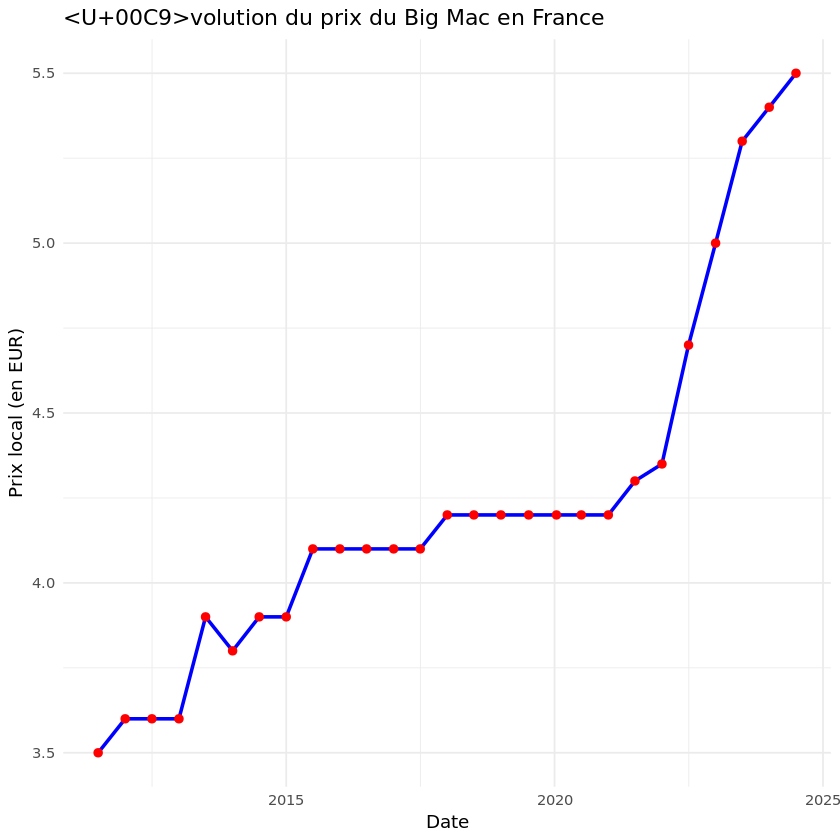

In [36]:
# Créer un graphique de l'évolution du prix du Big Mac en France
ggplot(big_mac_france, aes(x = date, y = local_price)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(
    title = "Évolution du prix du Big Mac en France",
    x = "Date",
    y = "Prix local (en EUR)"
  ) +
  theme_minimal()